In [1]:
# Upload kaggle.json first (same as before)
from google.colab import files
files.upload()  # Select kaggle.json

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d johnsmith88/heart-disease-dataset

# Unzip
!unzip heart-disease-dataset.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
License(s): unknown
  0% 0.00/6.18k [00:00<?, ?B/s]
100% 6.18k/6.18k [00:00<00:00, 24.1MB/s]
Archive:  heart-disease-dataset.zip
  inflating: heart.csv               


In [2]:
# Cell 1: install (kaggle already installed in many Colab images, but safe)
!pip install -q scikit-learn plotly

# Standard imports
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


In [3]:
# Cell 4: Load the CSV (replace filename below if different)
df = pd.read_csv("heart.csv")  # common name; change if your csv name differs
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
df.info()
print("\nMissing values per column:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())


Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        

In [4]:
# Cell 5: Basic cleaning
# 1) Drop duplicates (if any)
df = df.drop_duplicates().reset_index(drop=True)
print("After dropping duplicates, shape:", df.shape)

# 2) If any obvious impossible zeros or placeholders exist, inspect them:
display(df.describe(include='all').T)

# 3) If missing values exist, for now we'll impute later in pipeline.


After dropping duplicates, shape: (302, 14)


,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
exang,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


from matplotlib import pyplot as plt
_df_0['mean'].plot(kind='hist', bins=20, title='mean')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['std'].plot(kind='hist', bins=20, title='std')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['min'].plot(kind='hist', bins=20, title='min')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['25%'].plot(kind='hist', bins=20, title='25%')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='mean', y='std', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='std', y='min', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='min', y='25%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='25%', y='50%', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['count']
  ys = series['mean']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('count')
_ = plt.ylabel('mean')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['count']
  ys = series['std']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('count')
_ = plt.ylabel('std')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['count']
  ys = series['min']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('count')
_ = plt.ylabel('min')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['count']
  ys = series['25%']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('count')
_ = plt.ylabel('25%')

from matplotlib import pyplot as plt
_df_12['mean'].plot(kind='line', figsize=(8, 4), title='mean')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['std'].plot(kind='line', figsize=(8, 4), title='std')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['min'].plot(kind='line', figsize=(8, 4), title='min')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['25%'].plot(kind='line', figsize=(8, 4), title='25%')
plt.gca().spines[['top', 'right']].set_visible(False)

In [5]:
# Cell 6: target distribution (assume target column name 'target' or 'heartdisease' etc)
# Try common names and pick the existing one
possible_targets = ['target','heartdisease','HeartDisease','hd', 'output']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    # fallback: assume last column is target
    target_col = df.columns[-1]
print("Using target column:", target_col)
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))


Using target column: target
target
1    164
0    138
Name: count, dtype: int64
target
1    0.543046
0    0.456954
Name: proportion, dtype: float64


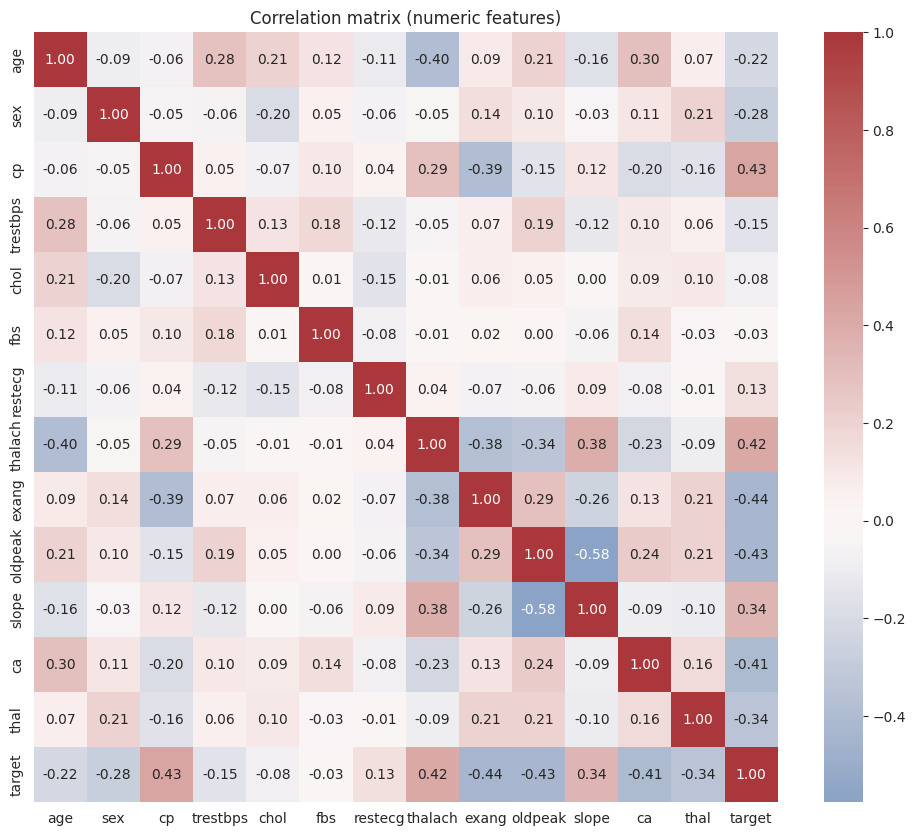

In [6]:
# Cell 7: correlation heatmap (numeric features only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numeric features)")
plt.show()


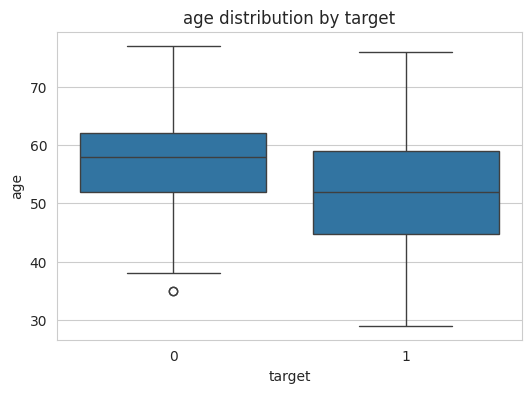

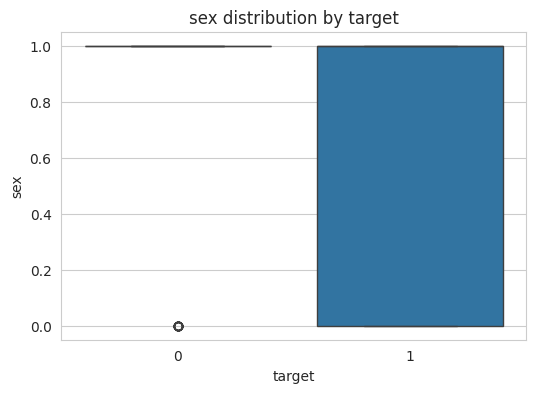

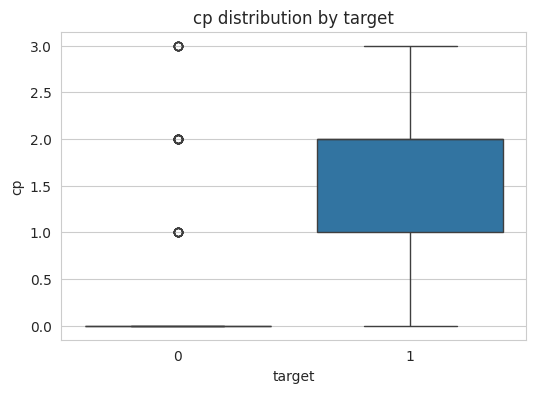

In [7]:
# Cell 8: some useful plots (choose 3 important numeric features)
# If columns exist, select them; otherwise pick first numeric ones
candidates = [c for c in num_cols if c!=target_col]
plot_cols = candidates[:3]  # top 3 numeric columns
for col in plot_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y=col, data=df)
    plt.title(f"{col} distribution by {target_col}")
    plt.show()

# Categorical variables distribution (if any)
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
for c in cat_cols:
    print("\nValue counts for", c)
    print(df[c].value_counts())


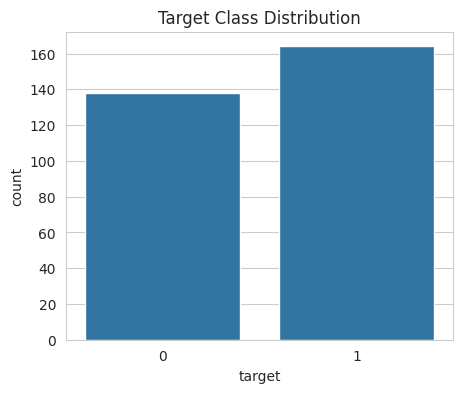

In [8]:
# Cell 9: class imbalance check (already printed but give visual)
plt.figure(figsize=(5,4))
sns.countplot(x=target_col, data=df)
plt.title("Target Class Distribution")
plt.show()


In [9]:
# Cell 10: features/target split
X = df.drop(columns=[target_col])
y = df[target_col]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (241, 13) Test shape: (61, 13)


In [10]:
# Cell 11: identify feature types
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical features: []


In [12]:
# ✅ Fixed Cell 12: Create preprocessing pipelines safely

# Numeric transformer (always present)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Build list of transformers
transformers = [('num', numeric_transformer, numeric_features)]

# Only add categorical transformer if there are categorical features
if categorical_features:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    transformers.append(('cat', categorical_transformer, categorical_features))

# Column transformer
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'  # drop unused columns
)
